In [1]:
# Model structure
# input layer >> 2D CNN >> 1D CNN >> RNN (LSTM)  >> output layer (Dense)

### Import module

In [2]:
from glob import glob
import os, sys
from os.path import join, dirname

import datetime, time
import csv
from glob import glob
import chardet
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Dense, SimpleRNN, LSTM, GRU, Reshape, Dropout, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG

import imblearn

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
device_lib.list_local_devices()

2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9266412417316748300,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15594058652304138290
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973147
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4799988611098435099
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12755133327561341058
 physical_device_desc: "device: XLA_GPU device"]

### Global Parameter

In [3]:
num_classes = 8                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}
time_offset = 10
window_size = 10
overlap_ratio = 0.5
bi_class = 6                              # Binary Classification (1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
cross_val = 0
rand_st=1
mode = 0                                 # Split data {0: Didn't split, 1: US only, 2: Korea only, 3: train with US and test with Korea 4: train with Korea and test with US}

### Load Data

In [4]:
data_fname = '../Data/Preprocessed/preprocessed_data(with_4_korean_scaled).csv'

### Preprocess Data

In [5]:
data = pd.read_csv(data_fname)
data = pd.concat([data,pd.get_dummies(data['sound_cat'])],axis=1)         # Onehot encode sound category
data = pd.concat([data,pd.get_dummies(data['orient'])],axis=1)            # Onehot encode Orient

In [6]:
# Create rowID list
rowID_list = np.array(data['RowID'].drop_duplicates())
data = data.to_records(index=False)

In [7]:
# Split US and Korea
us_rowIDs = []
korea_rowIDs = []

if mode != 0:
    for rowid in rowID_list:
    #     print(rowid, rowid[0])
        if rowid[0] == '1':
            korea_rowIDs.append(rowid)
        else:
            us_rowIDs.append(rowid)

In [8]:
for i in range(len(data)):
    #Convert string to num
    if data[i]['sound_cat'] == 'Quiet':
        data[i]['sound_cat'] = 0
    elif data[i]['sound_cat'] == 'Moderate':
        data[i]['sound_cat'] = 1
    else:
        data[i]['sound_cat'] = 2
    
    if data[i]['orient'] == 'Portrait Up':
        data[i]['orient'] = 0
    elif data[i]['orient'] == 'Portrait Down':
        data[i]['orient'] = 1
    elif data[i]['orient'] == 'Landscape Right':
        data[i]['orient'] = 2
    elif data[i]['orient'] == 'Landscape Left':
        data[i]['orient'] = 3
    else:
        data[i]['orient'] = 4

In [9]:
feature_col_name = ['awake', 'sound_val', 'light_val', 'accel_x', 'accel_y', 'accel_z', 'chord', 'motion_detect','sound_detect)',
                   'Loud', 'Moderate', 'Quiet', 'Flat', 'Landscape Left', 'Landscape Right', 'Portrait Down', 'Portrait Up']
target_col_name = ['Modality_cat']

In [10]:
X = []
us_X = []
korea_X = []

Y = []
us_Y = []
korea_Y = []


if mode != 0:
    for rowID in us_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        us_X.append(feature)
        us_Y.append(target)
    
    for rowID in korea_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        korea_X.append(feature)
        korea_Y.append(target)

else:
    for rowID in rowID_list:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        X.append(feature)
        Y.append(target)

In [11]:
if bi_class != 0:
    #Transit multi classification to binary classification
    if mode != 0:
        for idx in range(len(us_Y)):
            if us_Y[idx] == bi_class-1:
                us_Y[idx]=1
            else:
                us_Y[idx]=0
                
        for idx in range(len(korea_Y)):
            if korea_Y[idx] == bi_class-1:
                korea_Y[idx]=1
            else:
                korea_Y[idx]=0
    else:
        for idx in range(len(Y)):
            if Y[idx] == bi_class-1:
                Y[idx]=1
            else:
                Y[idx]=0

In [12]:
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

In [13]:
if mode != 0:
    us_X = X_preprocess(us_X, window_size, overlap_ratio)        ### preprocess with input shape
    korea_X = X_preprocess(korea_X, window_size, overlap_ratio)
    if bi_class == 0:
        ### onehot encode Y
        us_Y = np.eye(num_classes)[us_Y]
        korea_Y = np.eye(num_classes)[korea_Y]
    else: 
        us_Y = np.eye(2)[us_Y]
        korea_Y = np.eye(2)[korea_Y]

else:    
    X = X_preprocess(X, window_size, overlap_ratio)        ### preprocess with input shape
    if bi_class == 0:
        ### onehot encode Y
        Y = np.eye(num_classes)[Y]
    else: Y = np.eye(2)[Y]

In [14]:
# Subsample X Data size

def subsample(X, min_us_len, min_korea_len):
    sampled_X = []
    addon = 0
    
    if min_korea_len > min_us_len:
        if np.array(X).shape[1] == min_us_len:
            return X
        else:
            interval = min_korea_len / min_us_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_us_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

                sampled_X.append(temp_X)
            
    else:
        if np.array(X).shape[1] == min_korea_len:
            return X
        else:
            interval = min_us_len / min_korea_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_korea_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

            sampled_X.append(temp_X)
                    
    return sampled_X

In [15]:
# Fit to minimum length

min_len = 99999999
min_us_len = 99999999
min_korea_len = 99999999
min_X = []
min_us_X = []
min_korea_X = []

if mode == 0:
    for x in X:
        if len(x) < min_len:
            min_len = len(x)

    for x in X:
        min_X.append(x[:min_len])

else:
    for x in us_X:
        if len(x) < min_us_len:
            min_us_len = len(x)
            
    for x in korea_X:
        if len(x) < min_korea_len:
            min_korea_len = len(x)
            
    if mode == 1:
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    elif mode == 2:
        min_korea_len = 60
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    else:
        if min_korea_len < min_us_len:
            min_len = min_korea_len
        else: min_len = min_us_len

        for x in us_X:
            min_us_X.append(x[:min_len])

        for x in korea_X:
            min_korea_X.append(x[:min_len])

In [16]:
# Drop duplicate

if bi_class != 0:
    
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        for i in range(len(Y)):
            if Y[i][1] == 1:
                target_list.append(i)

        for i in target_list:
            for j in range(len(min_X)):
                if j in target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_X[i]), np.array(min_X[j])):
                        if j not in del_list:
                            del_list.append(j)
        X = []
        Target = []

        for i in range(len(Y)):
            if i not in del_list:
                X.append(min_X[i])
                Target.append(Y[i])
                
    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)
                            
        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)
        
        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])
                
        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

In [17]:
if mode == 0:
#     X = subsample(X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)
    
elif mode == 1:
    us_X = subsample(us_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(us_X, us_Target, test_size=0.2)

elif mode == 2:
    korea_X = subsample(korea_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(korea_X, korea_Target, test_size=0.2)

elif mode == 3:
    X_train = subsample(us_X, min_us_len, min_korea_len)
    X_test = subsample(korea_X, min_us_len, min_korea_len)
    Y_train = us_Target 
    Y_test = korea_Target

else:
    X_train = subsample(korea_X, min_us_len, min_korea_len)
    X_test = subsample(us_X, min_us_len, min_korea_len)
    Y_train = korea_Target
    Y_test = us_Target 

### Model

In [18]:
def build_model(num_classes, rnn_unit, input_shape):
    """ build CNN-RNN model """

    feature_input = Input(shape=input_shape)
    
    cnn_layer = Conv2D(1, 1, padding='same', activation='relu', name='conv1')(feature_input)
#     cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
    
    rnn_input = Reshape((-1, rnn_unit), name='reshape1')(cnn_layer)
    rnn_layer = LSTM(units=rnn_unit, activation='relu', recurrent_activation='sigmoid', return_sequences=None, name='rnn1')(rnn_input)
    rnn_output = Dense(units=num_classes, activation='softmax', name='fc1')(rnn_layer)
    
    model = Model(inputs=feature_input, outputs=rnn_output, name='CRNN')
    
    return model

In [19]:
def get_divisor(n):
    n = int(n)
    divisors = []
    divisors_back = [] 

    for i in range(1, int(n**(1/2)) + 1): 
        if (n % i == 0):            
            divisors.append(i)
            if (i != (n // i)): 
                divisors_back.append(n//i)

    return divisors + divisors_back[::-1]

### Train model

In [20]:
if bi_class == 0:    
    model = build_model(num_classes=num_classes, rnn_unit=100, input_shape=np.array(X_train[0]).shape)
    model.summary()
    plot_model(model, show_shapes=True, to_file='model.png')
    plt = SVG(model_to_dot(model).create(prog='dot', format='svg')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(), tfa.metrics.F1Score(num_classes=num_classes)])
else:
    sm = imblearn.over_sampling.SMOTE()         # random state do not set
    origin_shape = np.array(X_train).shape
    new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
    Y_train = np.eye(2)[Y_train.reshape(temp[0])]
    model = build_model(num_classes=2, rnn_unit=20, input_shape=np.array(X_train[0]).shape)
    model.summary()
    plot_model(model, show_shapes=True, to_file='model.png')
    SVG(model_to_dot(model).create(prog='dot', format='svg')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

C:\Users\sckim\.conda\envs\grad\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Model: "CRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 10, 17)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 10, 1)         18        
_________________________________________________________________
reshape1 (Reshape)           (None, 10, 20)            0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 20)                3280      
_________________________________________________________________
fc1 (Dense)                  (None, 2)                 42        
Total params: 3,340
Trainable params: 3,340
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=Y_train, batch_size=None, validation_split=0, epochs=500)

Epoch 1/500
7/7 [==============================] - 0s 21ms/step - loss: 5.4275 - accuracy: 0.5194 - auc: 0.5365
Epoch 2/500
7/7 [==============================] - 0s 19ms/step - loss: 5.4096 - accuracy: 0.5388 - auc: 0.5657
Epoch 3/500
7/7 [==============================] - 0s 21ms/step - loss: 5.1963 - accuracy: 0.5291 - auc: 0.5556
Epoch 4/500
7/7 [==============================] - 0s 19ms/step - loss: 4.8160 - accuracy: 0.5146 - auc: 0.5558
Epoch 5/500
7/7 [==============================] - 0s 21ms/step - loss: 4.7268 - accuracy: 0.5291 - auc: 0.5585
Epoch 6/500
7/7 [==============================] - 0s 21ms/step - loss: 4.6755 - accuracy: 0.5825 - auc: 0.5920
Epoch 7/500
7/7 [==============================] - 0s 18ms/step - loss: 5.2193 - accuracy: 0.5680 - auc: 0.5570
Epoch 8/500
7/7 [==============================] - 0s 18ms/step - loss: 4.2887 - accuracy: 0.6408 - auc: 0.6401
Epoch 9/500
7/7 [==============================] - 0s 18ms/step - loss: 4.2830 - accuracy: 0.6262 - auc:

7/7 [==============================] - 0s 16ms/step - loss: 0.6691 - accuracy: 0.6456 - auc: 0.6929
Epoch 74/500
7/7 [==============================] - 0s 16ms/step - loss: 0.6051 - accuracy: 0.7039 - auc: 0.7618
Epoch 75/500
7/7 [==============================] - 0s 17ms/step - loss: 0.6522 - accuracy: 0.6748 - auc: 0.7110
Epoch 76/500
7/7 [==============================] - 0s 17ms/step - loss: 0.5797 - accuracy: 0.7233 - auc: 0.7803
Epoch 77/500
7/7 [==============================] - 0s 23ms/step - loss: 0.5650 - accuracy: 0.7330 - auc: 0.7924
Epoch 78/500
7/7 [==============================] - 0s 20ms/step - loss: 0.5757 - accuracy: 0.6990 - auc: 0.7707
Epoch 79/500
7/7 [==============================] - 0s 18ms/step - loss: 0.5744 - accuracy: 0.6990 - auc: 0.7680
Epoch 80/500
7/7 [==============================] - 0s 16ms/step - loss: 0.5707 - accuracy: 0.7039 - auc: 0.7846
Epoch 81/500
7/7 [==============================] - 0s 16ms/step - loss: 0.5779 - accuracy: 0.6796 - auc: 0.7

Epoch 217/500
7/7 [==============================] - 0s 16ms/step - loss: 0.4683 - accuracy: 0.7184 - auc: 0.8535
Epoch 218/500
7/7 [==============================] - 0s 22ms/step - loss: 0.4861 - accuracy: 0.7864 - auc: 0.8664
Epoch 219/500
7/7 [==============================] - 0s 16ms/step - loss: 0.5375 - accuracy: 0.7330 - auc: 0.8385
Epoch 220/500
7/7 [==============================] - 0s 18ms/step - loss: 0.3877 - accuracy: 0.7913 - auc: 0.8941
Epoch 221/500
7/7 [==============================] - 0s 16ms/step - loss: 0.4265 - accuracy: 0.7718 - auc: 0.8690
Epoch 222/500
7/7 [==============================] - 0s 16ms/step - loss: 0.4034 - accuracy: 0.7573 - auc: 0.8758
Epoch 223/500
7/7 [==============================] - 0s 16ms/step - loss: 0.3888 - accuracy: 0.7864 - auc: 0.8906
Epoch 224/500
7/7 [==============================] - 0s 16ms/step - loss: 0.3809 - accuracy: 0.7767 - auc: 0.8951
Epoch 225/500
7/7 [==============================] - 0s 15ms/step - loss: 0.3701 - accur

Epoch 360/500
7/7 [==============================] - 0s 24ms/step - loss: 0.3155 - accuracy: 0.8010 - auc: 0.9204
Epoch 361/500
7/7 [==============================] - 0s 25ms/step - loss: 0.3251 - accuracy: 0.7816 - auc: 0.9176
Epoch 362/500
7/7 [==============================] - 0s 25ms/step - loss: 0.3174 - accuracy: 0.7864 - auc: 0.9191
Epoch 363/500
7/7 [==============================] - 0s 24ms/step - loss: 0.3080 - accuracy: 0.8107 - auc: 0.9243
Epoch 364/500
7/7 [==============================] - 0s 25ms/step - loss: 0.3566 - accuracy: 0.8107 - auc: 0.9149
Epoch 365/500
7/7 [==============================] - 0s 31ms/step - loss: 0.4725 - accuracy: 0.7379 - auc: 0.8594
Epoch 366/500
7/7 [==============================] - 0s 24ms/step - loss: 0.4037 - accuracy: 0.7476 - auc: 0.8696
Epoch 367/500
7/7 [==============================] - 0s 24ms/step - loss: 0.4541 - accuracy: 0.7379 - auc: 0.8531
Epoch 368/500
7/7 [==============================] - 0s 24ms/step - loss: 0.3875 - accur

In [22]:
## Train Confusion Matrix

train_predictions = model.predict(np.array(X_train).transpose([0,1,2,3]))

flatten_Y_train = []
flatten_train_predictions = []

for i in range(len(Y_train)):
    if Y_train[i][0] == 1:
        flatten_Y_train.append(0)
    else:
        flatten_Y_train.append(1)
        

for i in range(len(train_predictions)):
    if train_predictions[i][0] == 1:
        flatten_train_predictions.append(0)
    else:
        flatten_train_predictions.append(1)


conf_mat = confusion_matrix(flatten_Y_train, flatten_train_predictions)
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()
print(tn, fp, fn, tp)
print('Neg %:', tn/(tn+fp), 'Pos %:', tp/(tp+fn))

[[  7  96]
 [  0 103]]
7 96 0 103
Neg %: 0.06796116504854369 Pos %: 1.0


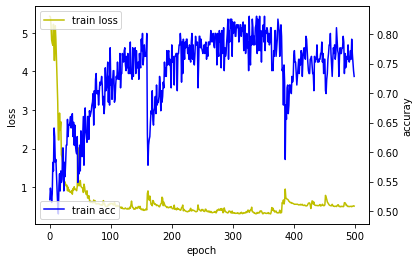

In [23]:
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### Test model

In [24]:
predictions = model.predict(np.array(X_test).transpose([0,1,2,3]))

if bi_class==0:
    auc = roc_auc_score(Y_test, predictions, multi_class='raise')
    print('Multiclass Test AUC: ', auc)
else:
    auc = roc_auc_score(Y_test, predictions)
    print('Test AUC: ', auc)

Test AUC:  0.7716346153846154


In [25]:
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1

frequency

array([29., 13.])

In [26]:
if bi_class == 0:
    test_loss, test_acc, test_auc, test_F1 = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)
else:
    test_loss, test_acc, test_auc = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)

2/2 - 0s - loss: 1.0526 - accuracy: 0.7381 - auc: 0.7999

Accuracy: 0.738095223903656


In [27]:
## Test Confusion Matrix

flatten_Y_test = []
flatten_predictions = []

for i in range(len(Y_test)):
    if Y_test[i][0] == 1:
        flatten_Y_test.append(0)
    else:
        flatten_Y_test.append(1)


for i in range(len(predictions)):
    if predictions[i][0] == 1:
        flatten_predictions.append(0)
    else:
        flatten_predictions.append(1)
        

conf_mat = confusion_matrix(flatten_Y_test, flatten_predictions)
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()
print(tn, fp, fn, tp)
print('Neg %:', tn/(tn+fp), 'Pos %:', tp/(tp+fn))

[[ 1 25]
 [ 0 16]]
1 25 0 16
Neg %: 0.038461538461538464 Pos %: 1.0
